In [ ]:

!pip install keras-tuner -q #install keras tuner here

import tensorflow as tf
import os
from google.colab import drive


drive.mount('/content/drive')

print("Google Drive is connected.")
print("TensorFlow version:", tf.__version__) #Check tensorflow version

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive is connected.
TensorFlow version: 2.19.0


In [ ]:

import pandas as pd
import os

drive_path = '/content/drive/MyDrive/Colab_Datasets/brain-tumor-mri-dataset' #connect googlr drive path

# Now we'll create variables that point directly to the folders AND the CSV files.
train_dir = os.path.join(drive_path, 'Training')
test_dir = os.path.join(drive_path, 'Testing')

train_csv_path = os.path.join(train_dir, '_annotations.csv')
test_csv_path = os.path.join(test_dir, '_annotations.csv')

col_names = ['filename', 'x_min', 'y_min', 'x_max', 'y_max', 'class']

try:
    # Use header=None and names=col_names
    train_df = pd.read_csv(train_csv_path, header=None, names=col_names)
    test_df = pd.read_csv(test_csv_path, header=None, names=col_names)

    print("Successfully loaded the CSV files with correct headers! Here's a look:")
    print(train_df.head())

except FileNotFoundError:
    print("I couldn't find the _annotations.csv files at the specified path.")
    print("Please double-check the 'drive_path' in this cell and make sure the CSV files are there.")

Successfully loaded the CSV files with correct headers! Here's a look:
                                            filename  x_min  y_min  x_max  \
0  Tr-me_0115_jpg.rf.661aa2cbe08aa66e85cbc93abef2...    235    336    340   
1  Tr-pi_0651_jpg.rf.65b66f7ecf2a2fa619ace12b21f9...    246    230    379   
2  Tr-no_0214_jpg.rf.65ff2f100fb3d80b174e88648b3c...    113    117    502   
3  Tr-no_0303_jpg.rf.675351270a549b44cdfbc7c219cb...    168    125    481   
4  Tr-no_0036_jpg.rf.65da5be208dc97700ee464b3d950...    178     81    421   

   y_max       class  
0    420  Meningioma  
1    316   Pituitary  
2    456    No Tumor  
3    523    No Tumor  
4    601    No Tumor  


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# This is our "recipe" for augmenting training images. It's the same as before.
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values from 0-255 to 0-1.
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2       # We'll still use 20% of the training data for validation.
)

# For testing, we only rescale. No augmentation!
test_datagen = ImageDataGenerator(rescale=1./255)

print("Data augmentation are ready!")

Data augmentation are ready!


In [ ]:
#define our image size and batch size.
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Training Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    subset="training",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=IMG_SIZE
)

# Validation Generator
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=IMG_SIZE
)

# Test Generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col='class',
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode="categorical",
    target_size=IMG_SIZE
)

print("\n Successfully created data generators from the CSV files!")
print("\nFound the following classes:", list(train_generator.class_indices.keys()))

Found 1374 validated image filenames belonging to 4 classes.
Found 343 validated image filenames belonging to 4 classes.
Found 250 validated image filenames belonging to 4 classes.

 Successfully created data generators from the CSV files!

Found the following classes: ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']


/tmp/ipython-input-930418618.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=train_class_counts, palette='viridis')
/tmp/ipython-input-930418618.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=test_class_counts, palette='plasma')


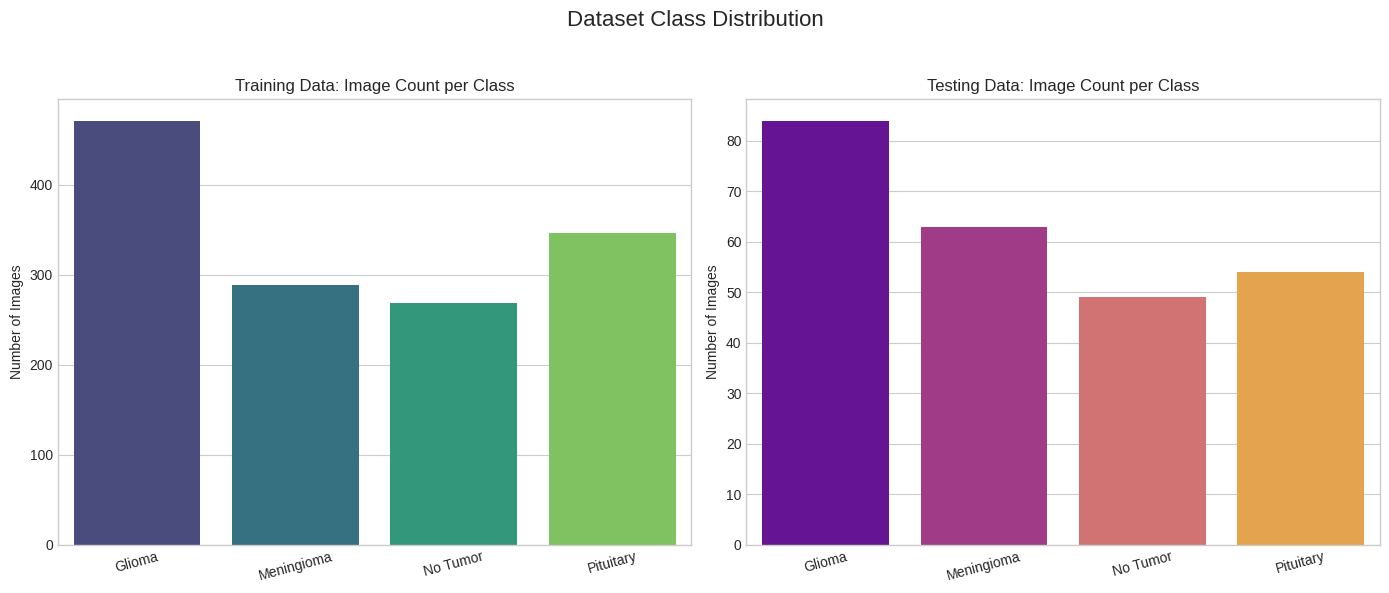

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Count the images in each class for the training set
train_class_counts = np.bincount(train_generator.classes)
class_names = list(train_generator.class_indices.keys())

# now for the test set
test_class_counts = np.bincount(test_generator.classes)


plt.figure(figsize=(14, 6))
plt.style.use('seaborn-v0_8-whitegrid')

plt.subplot(1, 2, 1)
sns.barplot(x=class_names, y=train_class_counts, palette='viridis')
plt.title('Training Data: Image Count per Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=15)

plt.subplot(1, 2, 2)
sns.barplot(x=class_names, y=test_class_counts, palette='plasma')
plt.title('Testing Data: Image Count per Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=15)

plt.suptitle('Dataset Class Distribution', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

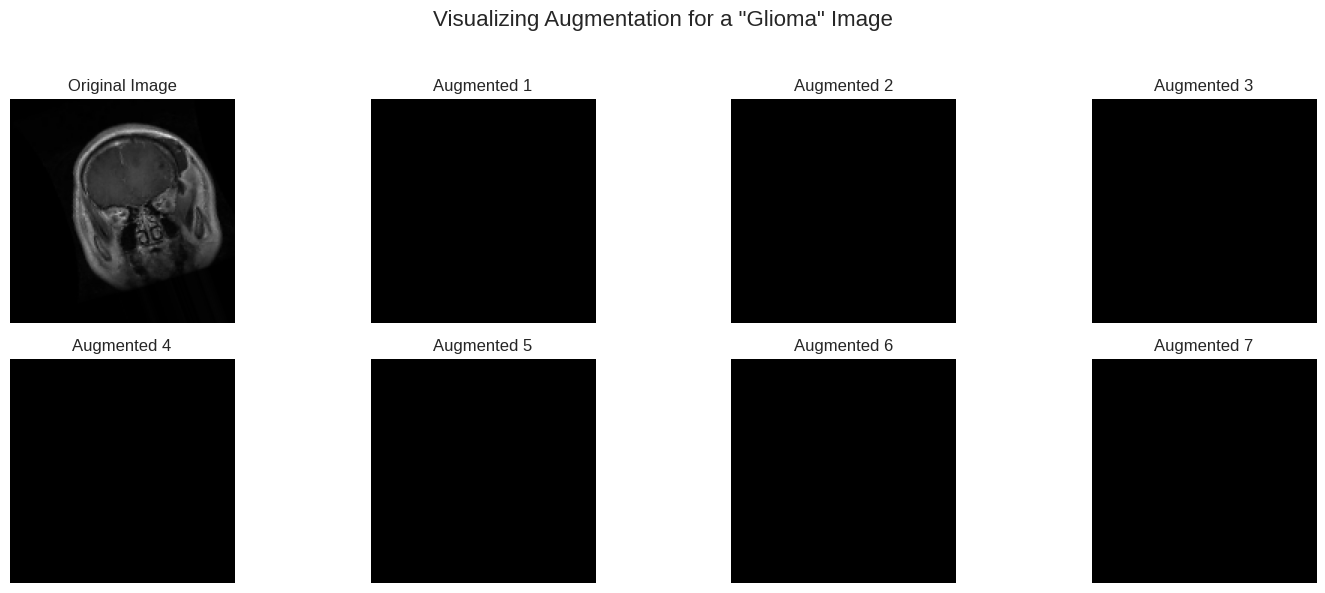

In [ ]:
#cell 6

# Grab one batch of images and labels from our training generator
images, labels = next(train_generator)

# Get the class names from the generator
class_names = list(train_generator.class_indices.keys())

#Pick the first image from this batch to visualize
first_image = images[0]
first_label_index = labels[0].argmax() # Find the index of the '1' in the one-hot encoded label
class_name = class_names[first_label_index]


plt.figure(figsize=(15, 6))
plt.suptitle(f'Visualizing Augmentation for a "{class_name}" Image', fontsize=16)

plt.subplot(2, 4, 1)
plt.imshow(first_image)
plt.title('Original Image')
plt.axis('off')

for i in range(7):
    augmented_image = train_datagen.flow(np.expand_dims(first_image, 0), batch_size=1)[0][0]
    plt.subplot(2, 4, i + 2)
    plt.imshow(augmented_image)
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
#cell 7
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    """This function builds our CNN model and lets the tuner play with its settings."""
    model = Sequential()

    # We'll let the tuner decide how many filters to use.
    hp_filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    model.add(Conv2D(filters=hp_filters, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(2, 2))

    # Let's add a couple more layers
    model.add(Conv2D(filters=hp_filters * 2, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(filters=hp_filters * 4, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))

    model.add(Flatten())

    # Now for the "brain" of the network. The tuner will pick the number of neurons.
    hp_units = hp.Int('units', min_value=256, max_value=512, step=128)
    model.add(Dense(units=hp_units, activation='relu'))


    hp_dropout = hp.Float('dropout', min_value=0.25, max_value=0.5, step=0.05) # Dropout is a technique to prevent our model from just memorizing the data.
    model.add(Dropout(rate=hp_dropout))

    model.add(Dense(4, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("Model-building function is ready for the tuner.")

✅ Model-building function is ready for the tuner.


In [ ]:
# cell 8

# We'll use the Hyperband tuner, which is a smart and efficient algorithm for searching.
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=8, # The maximum number of epochs to train a single model for.
    factor=3,
    directory='tuner_results',
    project_name='brain_tumor_classification_v2' #Use a new name to avoid old results
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("Starting the hyperparameter search! This might take some time...")
tuner.search(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[stop_early]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n Search complete! Here are the best settings found:")
print(f"   - Filters: {best_hps.get('filters')}")
print(f"   - Dense Units: {best_hps.get('units')}")
print(f"   - Dropout Rate: {round(best_hps.get('dropout'), 2)}")
print(f"   - Learning Rate: {best_hps.get('learning_rate')}")

Trial 10 Complete [00h 03m 31s]
val_accuracy: 0.7463557124137878

Best val_accuracy So Far: 0.7900874614715576
Total elapsed time: 00h 29m 08s

 Search complete! Here are the best settings found:
   - Filters: 96
   - Dense Units: 384
   - Dropout Rate: 0.35
   - Learning Rate: 0.0001


In [ ]:
# cell 9
# Build the model with the best hyperparameters found by the tuner.
final_model = tuner.hypermodel.build(best_hps)

final_model.summary()

print("\n Training the final model with the best settings...")


history = final_model.fit(
    train_generator,
    epochs=50, # Train for more epochs, but early stopping will halt it if needed.
    validation_data=validation_generator,
    callbacks=[stop_early]
)
print("\n Final model training is complete!")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 96)   │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 192)    │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 384)    │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 110976)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 384)            │    42,615,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,449,412 (165.75 MB)

 Trainable params: 43,449,412 (165.75 MB)

 Non-trainable params: 0 (0.00 B)


 Training the final model with the best settings...
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 498ms/step - accuracy: 0.4037 - loss: 1.3112 - val_accuracy: 0.5598 - val_loss: 1.1119
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 393ms/step - accuracy: 0.5022 - loss: 1.1196 - val_accuracy: 0.6735 - val_loss: 0.9568
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 402ms/step - accuracy: 0.6215 - loss: 0.9655 - val_accuracy: 0.6327 - val_loss: 0.9064
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 416ms/step - accuracy: 0.6766 - loss: 0.8364 - val_accuracy: 0.6676 - val_loss: 0.9518
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 451ms/step - accuracy: 0.6912 - loss: 0.8331 - val_accuracy: 0.7464 - val_loss: 0.7647
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 393ms/step - accuracy: 0.7019 - loss: 0.7776 - val_accuracy: 0.7318 - val_loss: 0.7048
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 423ms/step - accuracy: 0.6969 - loss: 0.7644 - val_accuracy: 0.7201 - val_loss: 0.6946
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 39

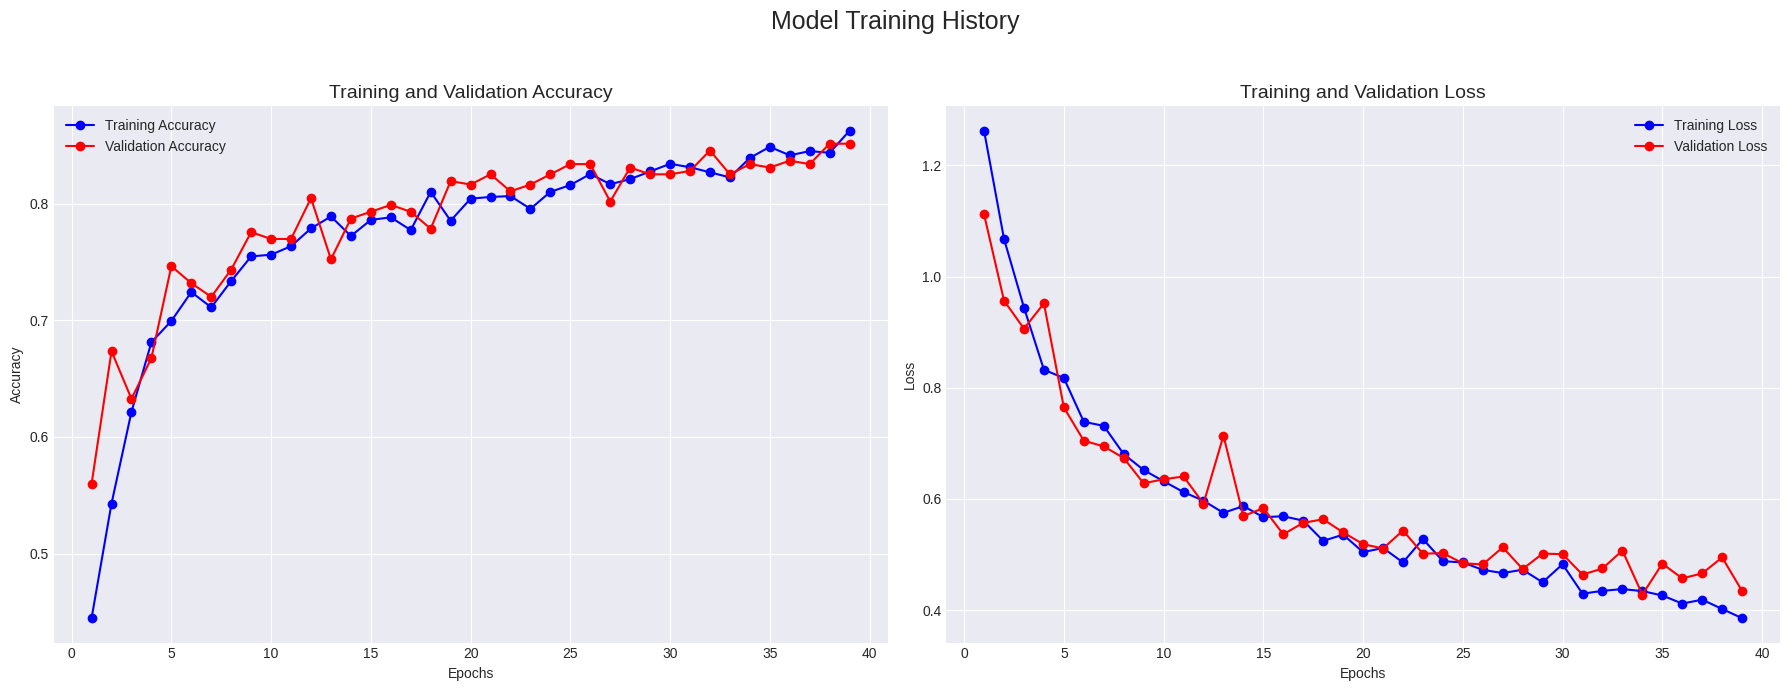

In [ ]:
#cell 10
import matplotlib.pyplot as plt
import seaborn as sns

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_ran = range(1, len(acc) + 1)

plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Model Training History', fontsize=18)

# Plot Training and Validation Accuracy
ax1.plot(epochs_ran, acc, 'bo-', label='Training Accuracy')
ax1.plot(epochs_ran, val_acc, 'ro-', label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy', fontsize=14)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot Training and Validation Loss
ax2.plot(epochs_ran, loss, 'bo-', label='Training Loss')
ax2.plot(epochs_ran, val_loss, 'ro-', label='Validation Loss')
ax2.set_title('Training and Validation Loss', fontsize=14)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
#cell 11
print(" Evaluating the model on the unseen test data...")

test_loss, test_acc = final_model.evaluate(test_generator)

print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

 Evaluating the model on the unseen test data...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 73s 10s/step - accuracy: 0.6827 - loss: 0.9872

Final Test Accuracy: 67.20%
Final Test Loss: 1.0613


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step


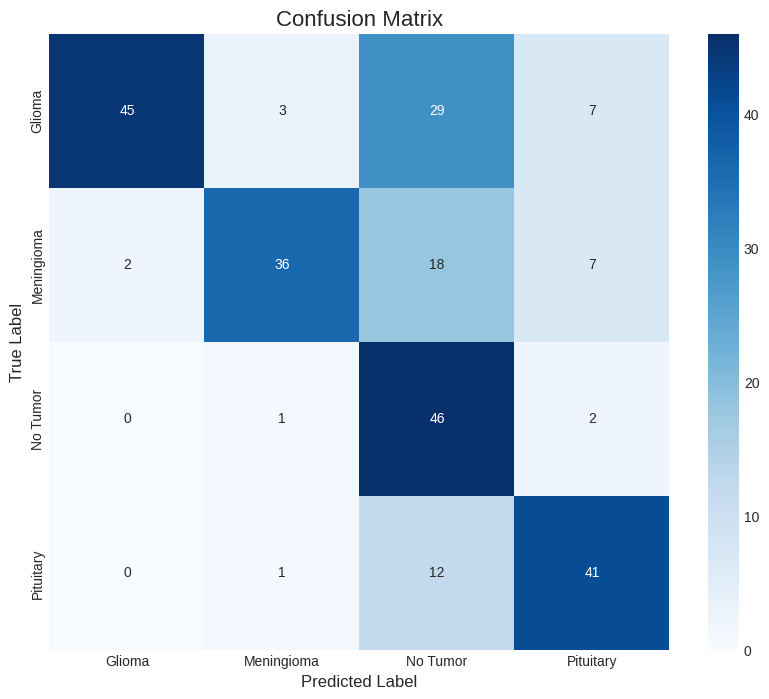


           CLASSIFICATION REPORT

              precision    recall  f1-score   support

      Glioma       0.96      0.54      0.69        84
  Meningioma       0.88      0.57      0.69        63
    No Tumor       0.44      0.94      0.60        49
   Pituitary       0.72      0.76      0.74        54

    accuracy                           0.67       250
   macro avg       0.75      0.70      0.68       250
weighted avg       0.78      0.67      0.68       250



In [ ]:
#cell 12
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

predictions = final_model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# Print the detailed classification report
print("\n" + "="*60)
print("           CLASSIFICATION REPORT")
print("="*60 + "\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


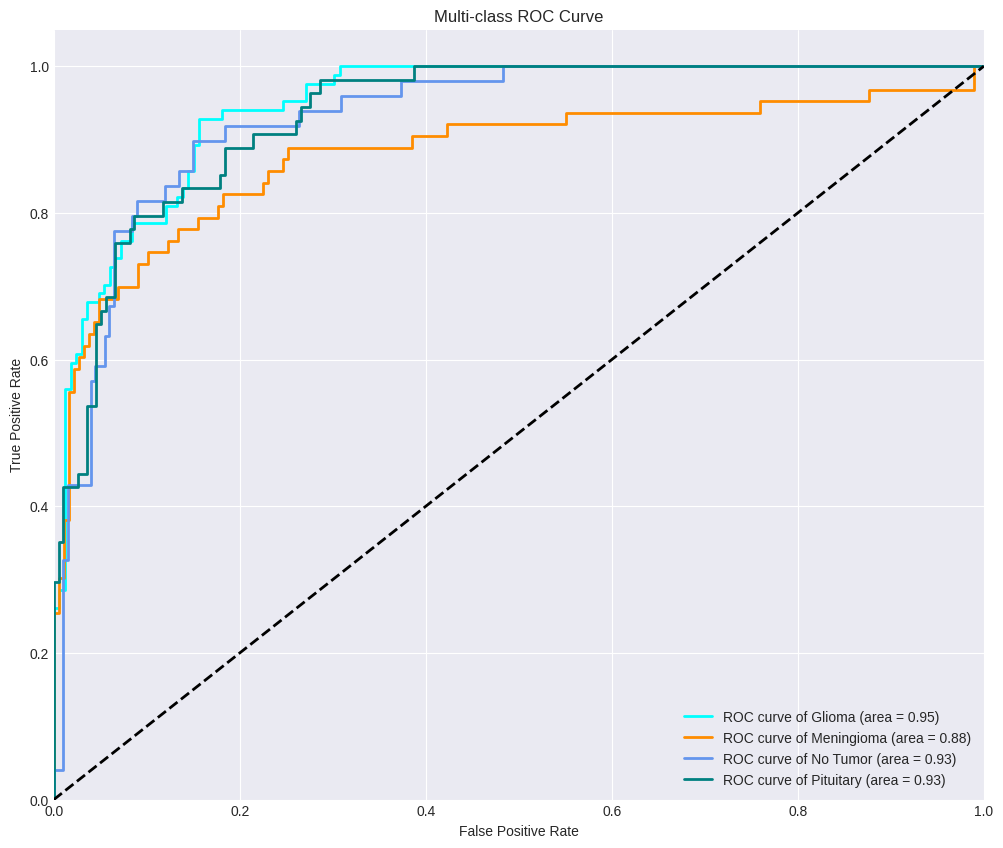

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Get the true labels and predicted probabilities for each class
y_true_onehot = label_binarize(y_true, classes=np.unique(y_true))
y_scores = final_model.predict(test_generator)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'teal'])
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.savefig('cnn_roc_curve.png') # Save the plot for your report
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


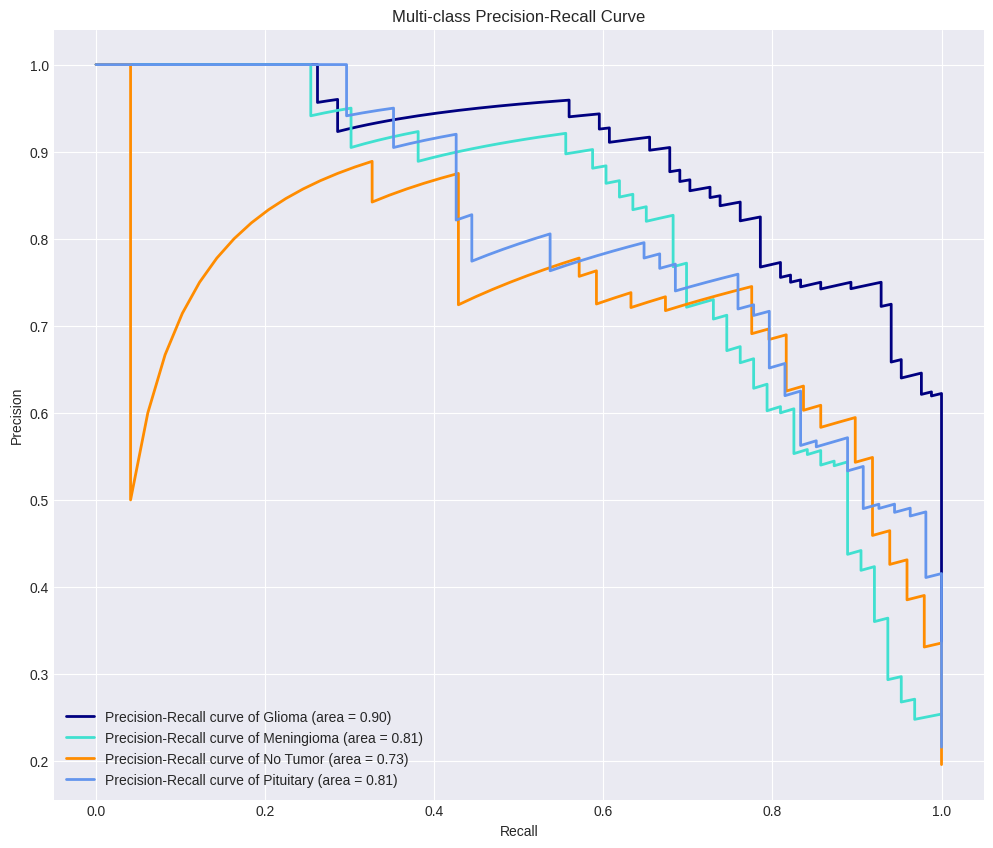

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

y_true_onehot = label_binarize(y_true, classes=np.unique(y_true))
y_scores = final_model.predict(test_generator)

precision = dict()
recall = dict()
pr_auc = dict()
for i in range(len(class_labels)):
    precision[i], recall[i], _ = precision_recall_curve(y_true_onehot[:, i], y_scores[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot all Precision-Recall curves
plt.figure(figsize=(12, 10))
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Precision-Recall curve of {class_labels[i]} (area = {pr_auc[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('cnn_pr_curve.png') # Save the plot for your report
plt.show()

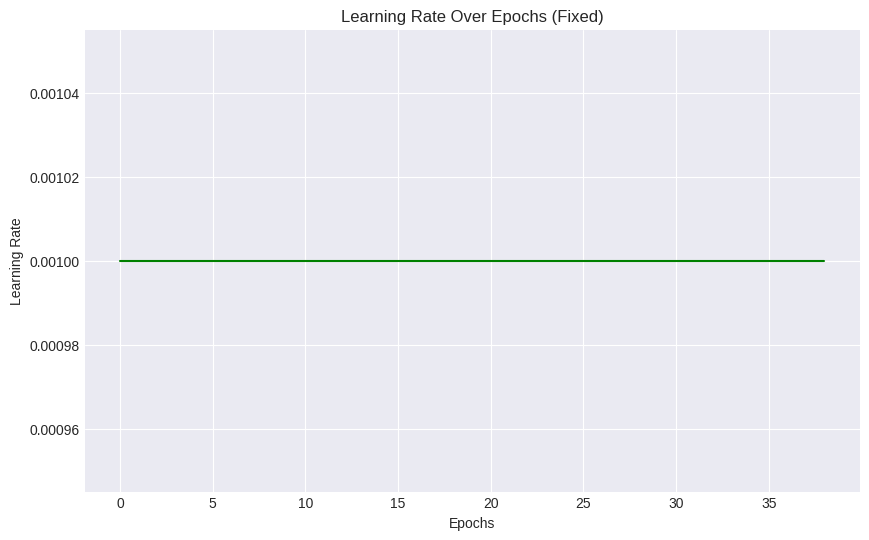

In [ ]:

history_df = pd.DataFrame(history.history)
history_df['lr'] = [0.001] * len(history_df) # Assuming your chosen learning rate was 0.001

plt.figure(figsize=(10, 6))
plt.plot(history_df.index, history_df['lr'], 'g-')
plt.title('Learning Rate Over Epochs (Fixed)')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.savefig('cnn_learning_rate.png')
plt.show()